In [1]:
import json
from pathlib import Path

import pandas
import plotly.express as px

In [2]:
benchmark_path = Path()

In [3]:
df_dict = {}
stat_dict = {}
for p in benchmark_path.glob('build-*-result.json'):
    build_name = p.stem.split('-', 2)[1]
    for browser_data in json.loads(p.read_text()):
        browser_name = f'{browser_data["browser"]["name"]} {browser_data["browser"]["major"]}'
        browser_name = browser_name.lower().replace('chrome headless', 'chromium')
        for result in (r for i, r in browser_data['result'].items() if i.isdigit()):
            key = build_name, browser_name, result['name']
            df_dict[key] = result['stats']['sample']
            stat_dict[key] = result['stats']

min_sample_size = min(len(v) for v in df_dict.values())
df_dict = {k: v[:min_sample_size] for k, v in df_dict.items()}
            
wide_df = pandas.DataFrame(df_dict).reset_index()
df = pandas.melt(
    wide_df, 
    id_vars='index', 
    var_name=['build', 'browser', 'test'], 
    value_name='duration',
)
df.sort_values(['build', 'index'], inplace=True)

In [4]:
stat_df = pandas.DataFrame(stat_dict)
stat_df = stat_df.loc[['mean', 'rme']].transpose()
stat_df.index = stat_df.index.set_names(['build', 'browser', 'test'])
stat_df = stat_df.reset_index().sort_values(['test', 'browser'], ascending=False)
for index, row in stat_df.iterrows():
    print('\t'.join([
        row['build'],
        row['browser'],
        row['test'],
        f'{row["mean"]:.2f} s ± {row["rme"]:.1f}%'
    ]))

pr	firefox 88	select	0.20 s ± 1.5%
master	firefox 88	select	0.22 s ± 1.3%
pr	chromium 90	select	0.18 s ± 1.1%
master	chromium 90	select	0.18 s ± 0.5%
pr	firefox 88	import	2.37 s ± 4.3%
master	firefox 88	import	2.64 s ± 2.6%
pr	chromium 90	import	1.67 s ± 0.7%
master	chromium 90	import	1.74 s ± 1.8%


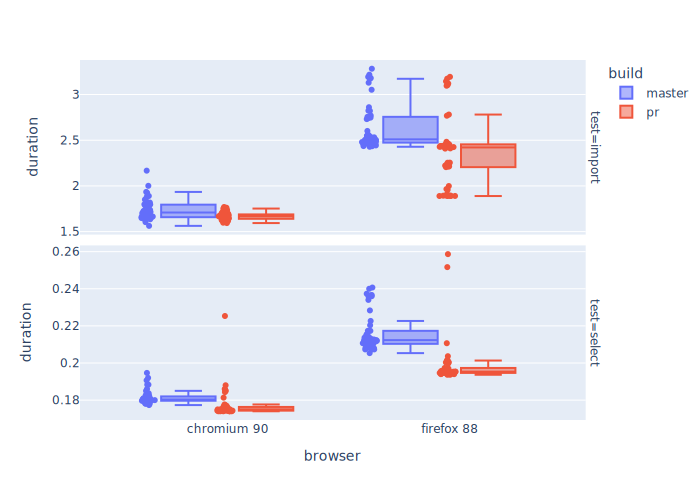

In [5]:
fig = px.box(df, x='browser', y='duration', points='all', color='build', facet_row='test')
fig.update_yaxes(matches=None)
fig.show('svg')

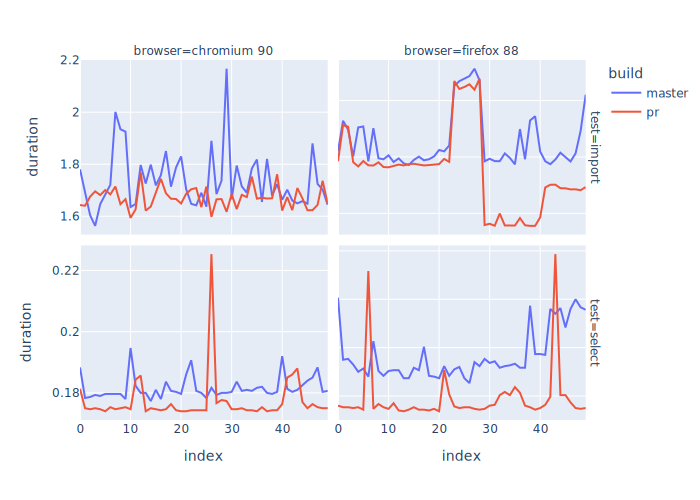

In [6]:
fig = px.line(
    df, x='index', y='duration', color='build', facet_col='browser', facet_row='test'
)
fig.update_yaxes(matches=None)
fig.show('svg')

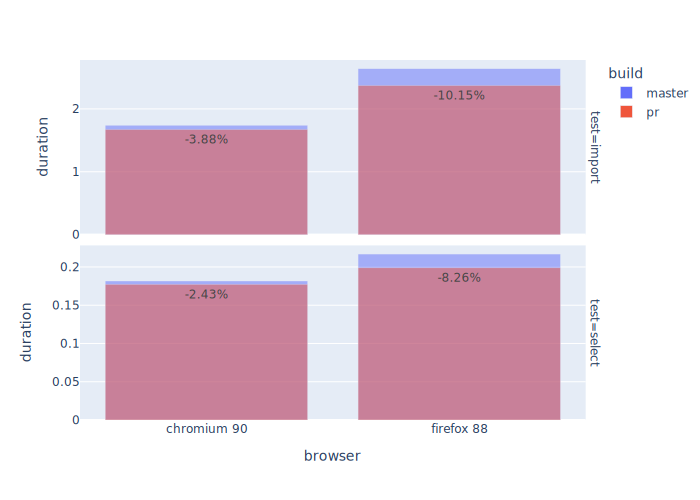

In [7]:
plot_df = df.groupby(['browser', 'build', 'test'])['duration'].mean().reset_index()
plot_df['pct'] = (
    plot_df
    .groupby(['browser', 'test'])['duration']
    .pct_change()
    .fillna('')
    .map(lambda v: '{:.2%}'.format(v) if v else v)
)
fig = px.bar(
    plot_df, 
    x='browser', 
    y='duration', 
    color='build', 
    text='pct', 
    barmode='overlay', 
    facet_row='test',
)
fig.update_yaxes(matches=None)
fig.show('svg')